# **Time Series Analysis for CoinGeckoAPI (Cryptocurrency)**

**Install the pycoingecko library, which is the official Python wrapper for the CoinGecko API.**

In [ ]:
#Install the CoinGeckoAPI Library
!pip install pycoingecko


# **Fetch Cryptocurrency Data Using CoinGecko API**

Retrieve data for the last 365 days using the CoinGecko API.



In [ ]:
from pycoingecko import CoinGeckoAPI
import pandas as pd

# Initialize the CoinGecko API client
cg = CoinGeckoAPI()

# Fetch historical data for Litecoin (LTC) in USD for the past 365 days
data = cg.get_coin_market_chart_by_id(id='litecoin', vs_currency='usd', days=365)

# Convert to DataFrame and format the date
df = pd.DataFrame(data['prices'], columns=['Date', 'Close'])
df['Date'] = pd.to_datetime(df['Date'], unit='ms')
df.set_index('Date', inplace=True)

# Display the data
print(df.head())


                Close
Date                 
2023-10-30  68.831865
2023-10-31  69.237382
2023-11-01  68.996787
2023-11-02  69.926616
2023-11-03  69.459248


# **Exploratory Data Analysis (EDA)**




**Data** **Cleaning** Handle Missing Values

In [ ]:
# Check for missing values
print("Missing values in the dataset:\n", df.isnull().sum())

# Forward fill any missing values if present
df.fillna(method='ffill', inplace=True)

Missing values in the dataset:
 Close    0
dtype: int64


<ipython-input-15-c28f204b8421>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


**Remove Outliers**

Since outliers can affect the accuracy of the model, let’s use the IQR method to identify and remove them.

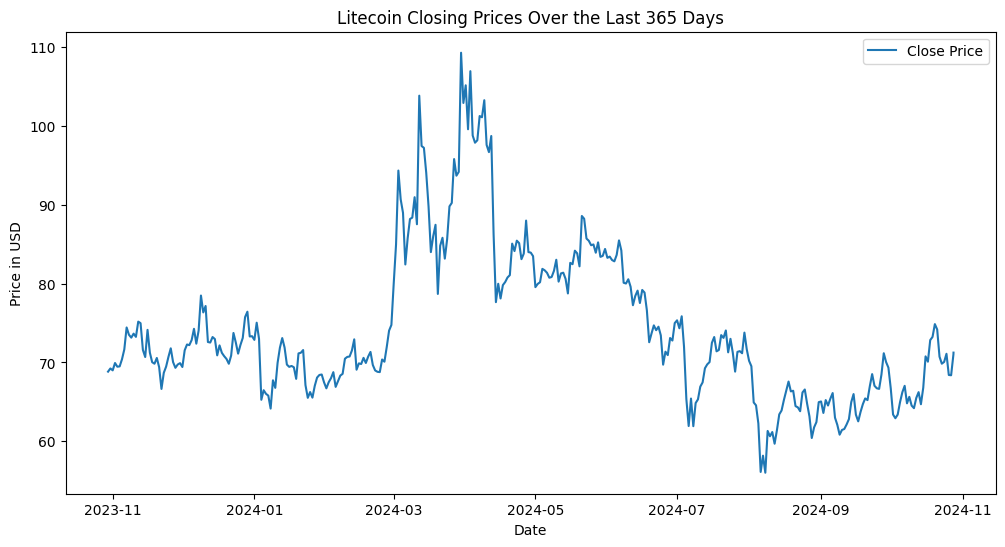

In [ ]:
import matplotlib.pyplot as plt

# Plot closing prices
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Close Price')
plt.title('Litecoin Closing Prices Over the Last 365 Days')
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.legend()
plt.show()


**Stationarity Check and Transformation**

Use the Augmented Dickey-Fuller (ADF) test to check for stationarity. If non-stationary, you may need to difference the data or apply transformations.

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test
adf_result = adfuller(df['Close'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

# Interpretation
if adf_result[1] > 0.05:
    print("The series is non-stationary.")
else:
    print("The series is stationary.")


ADF Statistic: -2.1048688385256975
p-value: 0.24256132952275927
The series is non-stationary.


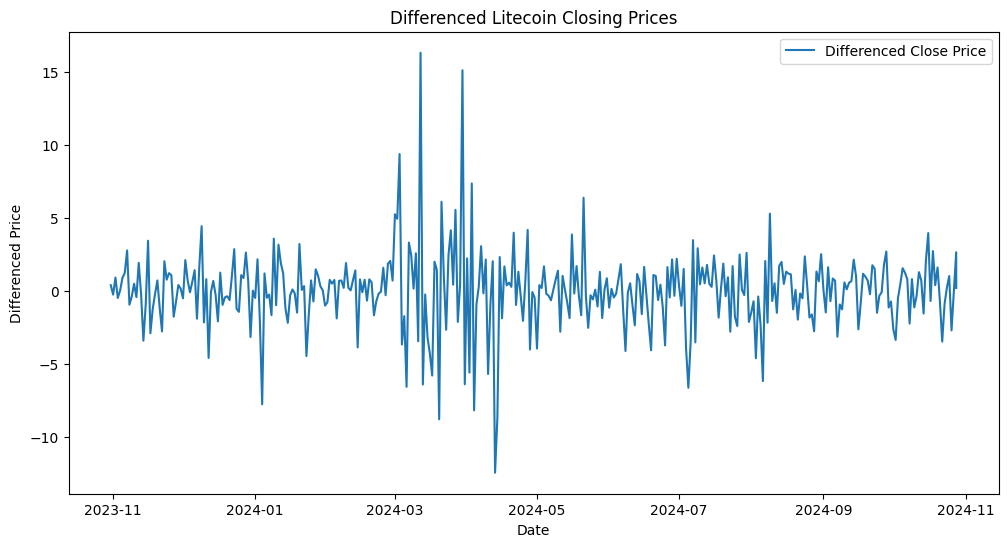

In [ ]:
# Differencing the data to make it stationary if needed
df_diff = df['Close'].diff().dropna()

# Plot differenced data
plt.figure(figsize=(12, 6))
plt.plot(df_diff, label='Differenced Close Price')
plt.title('Differenced Litecoin Closing Prices')
plt.xlabel('Date')
plt.ylabel('Differenced Price')
plt.legend()
plt.show()


# **Data Preparation for LSTM**

**Scaling the Data**

Scale the data between 0 and 1 to prepare it for the LSTM model.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Define the lookback period (e.g., 60 days)
lookback_period = 60
X, y = [], []

# Prepare sequences of lookback_period for training
for i in range(lookback_period, len(scaled_data)):
    X.append(scaled_data[i-lookback_period:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))


**Build and Train the LSTM Model**

Define and train the LSTM model on the cleaned, scaled data.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, epochs=10, batch_size=32)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.0981
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0160
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0124
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0126
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0094
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0093
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0071
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0097
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0084
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0086


**Make Predictions and Inverse Transform**

Use the trained LSTM model to predict future values and inverse the scaling.

In [ ]:
# Generate predictions for the last 30 days
predictions = model.predict(X[-30:])
predictions = scaler.inverse_transform(predictions)

# Prepare actual values for comparison
actual_prices = scaler.inverse_transform(y.reshape(-1, 1))[-30:]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


**Plot the Predictions**

Visualize the model’s predictions alongside the actual prices.



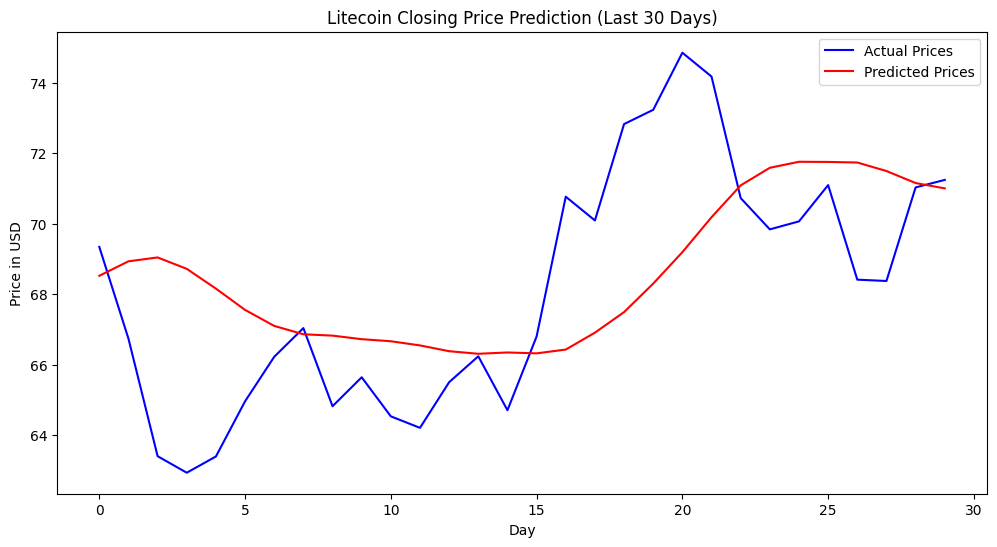

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(actual_prices)), actual_prices, color='blue', label='Actual Prices')
plt.plot(range(len(predictions)), predictions, color='red', label='Predicted Prices')
plt.title('Litecoin Closing Price Prediction (Last 30 Days)')
plt.xlabel('Day')
plt.ylabel('Price in USD')
plt.legend()
plt.show()


**Evaluate the Model**

Evaluate the performance of the model using RMSE.

In [ ]:
from sklearn.metrics import mean_squared_error

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_prices, predictions))
print(f'Root Mean Squared Error: {rmse}')


Root Mean Squared Error: 3.0420068604024078
